# Predicting whether or not a player is in the NBA next season

In this notebook we perform model selection with the goal of generating the best classifier for the response variable `IN_LEAGUE_NEXT`, whether or not a given player will play at any point in the next NBA season (and thus have stats data).

We will do all model selection using _only_ the set of training data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load the data and drop NAN rows

In [2]:
#load the data and drop NAN rows
df_train = pd.read_csv("train_data.csv").dropna()

## Correlations

Now we'll look at correlations between the predictors and the response variable.  Below we grab the numeric columns and make a correlation heatmap before printing the correlations with `IN_LEAGUE_NEXT`.

In [3]:
#grab all columns
all_cols = list(df_train.columns)

#grab just the columns with numeric data
num_cols = [all_cols[2]] + all_cols[4:6] + all_cols[7:]

#grab just the predictors for later; NOTE: leaving out SEASON_START as a predictor
predictors = num_cols[1:-1]

IN_LEAGUE_NEXT    1.000000
GP                0.478477
PF                0.437245
MIN               0.432902
FGM               0.375724
FGA               0.375195
PTS               0.370963
TOV               0.368588
WAIVED            0.364991
DREB              0.357475
STL               0.353853
REB               0.353068
WAIVED_REG        0.347859
DWS               0.344599
WS                0.335609
Name: IN_LEAGUE_NEXT, dtype: float64

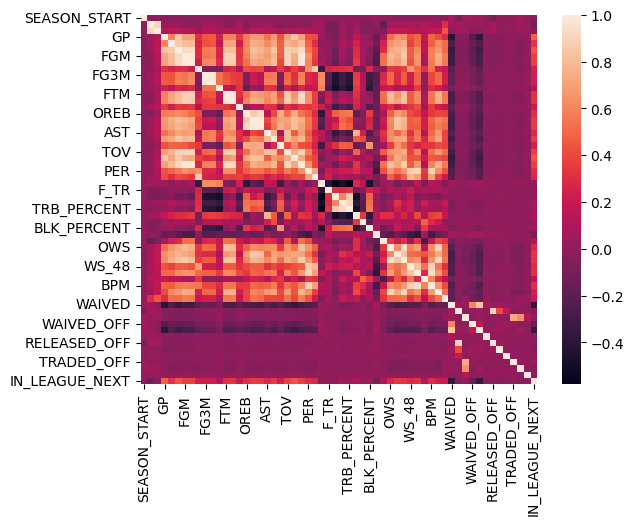

In [4]:
#compute correlations between numeric data columns
corr = df_train[num_cols].corr()

#plot heatmap
sns.heatmap(corr)

#print top 15 or so |correlations| with IN_LEAGUE_NEXT in descending order
abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)[0:15]

# Modeling

## Model 1: Naive logistic regression model

Let's begin by finding the 5-fold CV performance of a simple logistic regression model on the training set.

The primary metric we'll use to score the model's performance is the _balanced accuracy score_ (https://scikit-learn.org/dev/modules/model_evaluation.html#balanced-accuracy-score), which generalizes the accuracy score to imbalanced classes (which is the case here; see the cell immediately below).

In [5]:
#show that we have imbalanced classes
df_train.IN_LEAGUE_NEXT.value_counts(normalize=False)

IN_LEAGUE_NEXT
1.0    9420
0.0    1950
Name: count, dtype: int64

In [6]:
#import the functions we need for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [7]:
def compute_metrics(true_y_vals, predictions):
    """Compute metrics given true y values and classifier predictions.
       Returns a list with the following components: balanced accuracy 
       score, precision, recall, negative predictive value, and specificity."""
    
    #get the confusion matrix
    conf      = confusion_matrix(true_y_vals, predictions)
    
    #grab true negatives, true positives, false positives, false negatives
    tn = conf[0,0]
    tp = conf[1,1]
    fp = conf[0,1]
    fn = conf[1,0]

    #balanced accuracy score
    bal_accuracy = balanced_accuracy_score(true_y_vals, predictions)
    #precision (positive predictive value): what % of players classified as 1's are true 1's?
    precision    = tp/(tp+fp)
    #recall (sensitivity): what % of true 1's are classified as 1?
    recall       = tp/(tp+fn)
    #negative predictive value (NPV): what % of players classified as 0's are true 0's?
    npv          = tn/(tn+fn)
    #specificity: what % of true 0's are classified as 0?
    specificity  = tn/(tn+fp)


    return np.array([bal_accuracy, precision, recall, npv, specificity])

In [8]:
def crossValidation(model, resample_SMOTE=True):
    """Does 5-fold cross validation given a model. Prints classification metrics
       and displays the confusion matrix summed over all folds."""

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=815)
    metrics       = []
    conf_matrices = []

    for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
        #grab the raw training data and test data for this CV fold
        X_tt  = df_train[predictors].iloc[train_idx]
        y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
        X_val = df_train[predictors].iloc[test_idx]
        y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

        if resample_SMOTE:
            #resample the training data using SMOTE
            smote = SMOTE(random_state=5)
            X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)
        else:
            #do not resample
            X_tt_re, y_tt_re = X_tt, y_tt

        #train the model
        model.fit(X_tt_re, y_tt_re)
    
        #get prediction and balanced accuracy scores for validation set
        pred = model.predict(X_val)

        #compute metrics and append them to list
        metrics.append(compute_metrics(y_val, pred))

        #compute confusion matrix and append it to a list
        conf_matrices.append(confusion_matrix(y_val, pred))

        print(f"CV fold {i} complete")

    #print CV averaged metrics
    avg_bal_acc, avg_prec, avg_recall, avg_npv, avg_spec = np.mean(np.array(metrics), axis=0)
    full_conf_matrix                                     = np.sum(conf_matrices, axis=0)

    print("\n" + "Classification metrics")
    print(f"Avg bal. accuracy: {avg_bal_acc:.3f}")
    print(f"Avg precision:     {avg_prec:.3f}")
    print(f"Avg recall:        {avg_recall:.3f}")
    print(f"Avg NPV:           {avg_npv:.3f}")
    print(f"Avg specificity:   {avg_spec:.3f}")

    ConfusionMatrixDisplay(full_conf_matrix).plot()

    return None

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.691
Avg precision:     0.890
Avg recall:        0.955
Avg NPV:           0.664
Avg specificity:   0.428


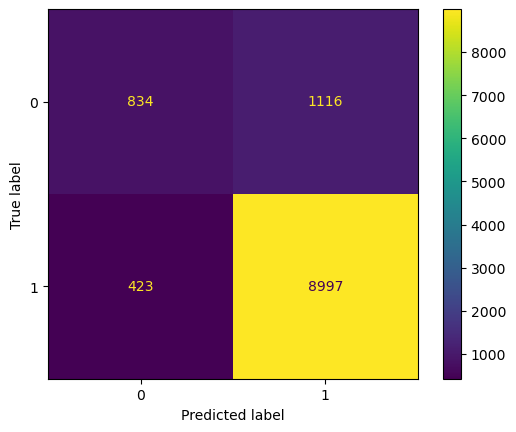

In [9]:
#define the model
lr = LogisticRegression(penalty=None, max_iter=10_000)

#run the crossValidation function on the model
crossValidation(lr, resample_SMOTE=False)

## Model 2: Logistic regression model trained on balanced classes

We'll now address the fact that our classes are imbalanced by augmenting the training data used in each CV fold.  To do so, we'll use the `imblearn` library's data augmentation functions.  Of these functions, I find that the Synthetic Minority Oversampling Technique (SMOTE) gives the best performance.

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.802
Avg precision:     0.955
Avg recall:        0.781
Avg NPV:           0.438
Avg specificity:   0.823


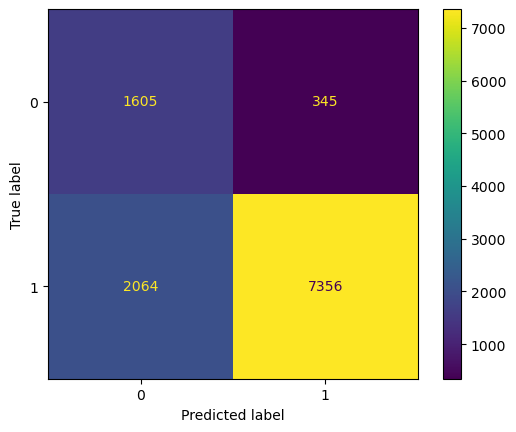

In [10]:
crossValidation(lr, resample_SMOTE=True)

### SMOTE-balanced training data gives improved performance.

Notice that the performance is about 10% better in terms of the balanced accuracy score, simply by training the model with a set of augmented data (from SMOTE).  That said, we have noticeably more false negatives after augmenting the data.

## Models 3a-b: Linear Discriminant Analysis, Naive Bayes Classifier

Here we will try a couple more classifiers in much the same way as above.  Specifically, we use Linear Discriminant Analysis (LDA) and the Naive Bayes Classifier.  

We do not use Quadratic Discriminant Analysis because many of our predictors are collinear, and the algorithm does not converge well; we could use PCA beforehand, but I find that the performance is still worse than LDA and Naive Bayes.

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.798
Avg precision:     0.955
Avg recall:        0.773
Avg NPV:           0.429
Avg specificity:   0.822


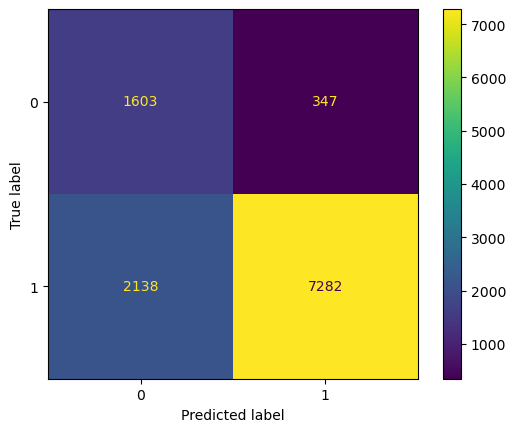

In [12]:
lda = LinearDiscriminantAnalysis()

crossValidation(lda)

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.774
Avg precision:     0.962
Avg recall:        0.679
Avg NPV:           0.359
Avg specificity:   0.869


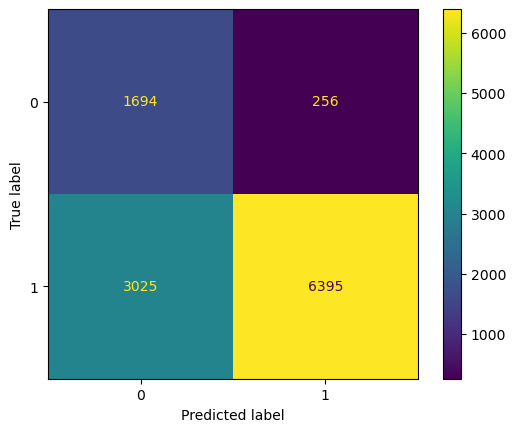

In [13]:
nb = GaussianNB()

crossValidation(nb)

### LDA is comparable to logistic regression; Naive Bayes is much worse.

The logistic regression model and the LDA model have about the same performance, trading off false positives and false negatives (LR has fewer FPs, LDA has fewer FNs).  The Naive Bayes model has very few FPs, but far more FNs.

## Models 4a-b: PCA + KNN, PCA + QDA

We will now consider a KNN model and a Quadratic Discriminant Analysis (QDA) model.  KNN is prone to the curse of dimensionality, so we will likely need to reduce the number of predictors before using it; we can do so using PCA.  QDA doesn't converge well if our predictors are collinear, as is the case here.  We'll use PCA to generate an orthogonal basis of predictors before using QDA.

In [14]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

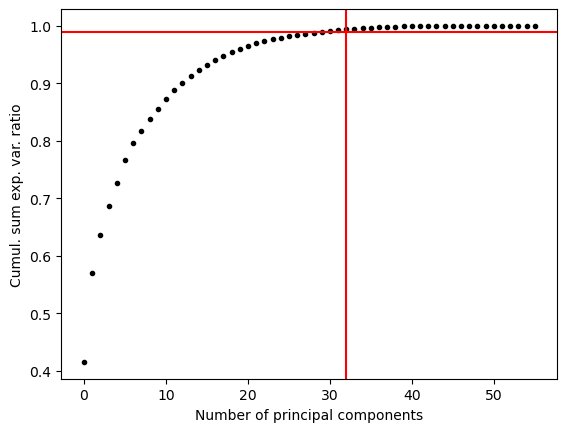

In [16]:
#scale the variables before applying PCA
pca = PCA(n_components=len(predictors))
pca.fit(df_train[predictors])

#grab the explained variance ratio
pca_EVR = pca.explained_variance_ratio_ #get the explained variance ratio

#get the cumulative sum of the explained variance ratio and plot it
pca_EVR_cumul = np.cumsum(pca_EVR)

plt.plot(pca_EVR_cumul, 'k.')
plt.xlabel("Number of principal components")
plt.ylabel("Cumul. sum exp. var. ratio")
plt.axhline(0.99, c='r')
plt.axvline(32, c='r')
plt.show()

### 32 principal components explain 99% of the variance in the predictors.

From the plot we can see that it takes 32 principal components to explain 99% of the variance in the predictors.  Hence we'll use 32 principal components in our KNN and QDA models.

KNN still has a hyperparameter (`n_neighbors`), so we will use a modified version of the `crossValidation` function to find it.

In [17]:
NUM_FOLDS = 5

kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=815)

MAX_KNN_K = 105

bal_acc_vs_k = np.zeros((NUM_FOLDS, MAX_KNN_K)) #store balanced accuracy score vs k (num_neighbors)

for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
    #grab the raw training data and test data for this CV fold
    X_tt  = df_train[predictors].iloc[train_idx]
    y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
    X_val = df_train[predictors].iloc[test_idx]
    y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

    #resample the training data using SMOTE
    smote = SMOTE(random_state=5)
    X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)

    for k in range(1, MAX_KNN_K+1):
        #train the model
        knn = Pipeline([("pca", PCA(32)), ("knn", KNeighborsClassifier(k))])
        knn.fit(X_tt_re, y_tt_re)
    
        #get prediction and balanced accuracy scores for validation set
        pred = knn.predict(X_val)

        #compute balanced_accuracy_score for each fold (i) and value of n_neighbors (k)
        bal_acc_vs_k[i, k-1] = balanced_accuracy_score(y_val, pred) #k-1 because k starts at 1

    print(f"CV fold {i} complete")

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete


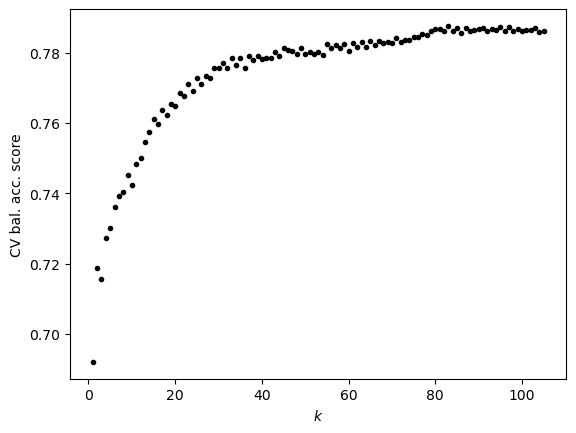

max bal. acc.: 0.788 for k = 82


In [18]:
knn_k         = range(1, MAX_KNN_K+1)
mean_acc_vs_k = np.mean(bal_acc_vs_k, axis=0)
best_k        = np.argmax(mean_acc_vs_k)

plt.plot(knn_k, mean_acc_vs_k, 'k.')
plt.xlabel('$k$')
plt.ylabel('CV bal. acc. score')
plt.show()

print(f"max bal. acc.: {np.amax(mean_acc_vs_k):.3f} for k = {best_k}")

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.787
Avg precision:     0.958
Avg recall:        0.726
Avg NPV:           0.391
Avg specificity:   0.847


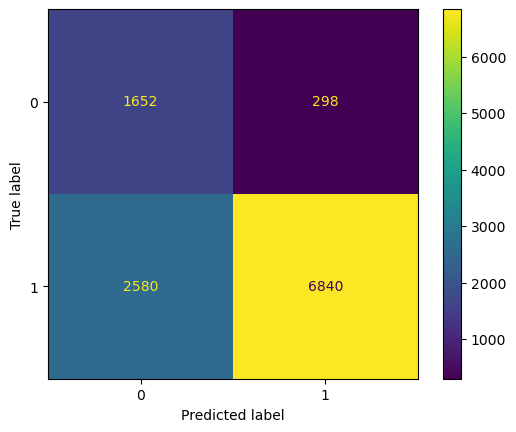

In [19]:
knn = Pipeline([("scale", StandardScaler()), ("pca", PCA(32)), ("knn", KNeighborsClassifier(best_k))])

crossValidation(knn)

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.749
Avg precision:     0.919
Avg recall:        0.870
Avg NPV:           0.501
Avg specificity:   0.628


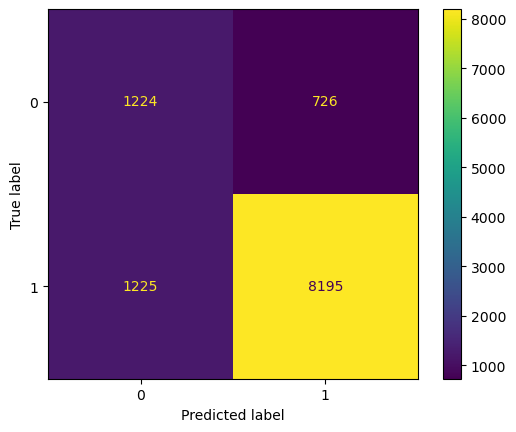

In [20]:
#now do QDA
qda = Pipeline([("scale", StandardScaler()), ("pca", PCA(32)), ("qda", QuadraticDiscriminantAnalysis())])

crossValidation(qda, False) #QDA performs better with SMOTE off!

### KNN is worse than logistic regression, LDA. QDA is comparable to log. reg. with SMOTE off.

Even with a tuned value of `num_neighbors`, KNN (with 32 principal components, which should explain > 99% of the variance of all predictors) performs noticeably worse than logistic regression and LDA.  It has few FPs, but many more FNs.  QDA has similar behavior with SMOTE on; for some reason, with SMOTE off, QDA has performance comparable to logistic regression.

## Model 5: Decision Tree Classifier

Now we try the decision tree classifier.  In this case we have a hyperparameter that needs tuning: the `max_depth`.  We find the best value for `max_depth` using `GridSearchCV`, and then run the same manual CV with the chosen value of `max_depth` to find the performance of the model and compute metrics.

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
#get the resampled data
smote   = SMOTE(random_state=5)
X_train = df_train[predictors]
y_train = df_train.IN_LEAGUE_NEXT
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

#make the GridSearchCV object, fit it, save the best value for max_depth
dt        = DecisionTreeClassifier(random_state=25)
tree_gscv = GridSearchCV(dt, {"max_depth":range(1, 15)}, cv=5, 
                         scoring="balanced_accuracy", verbose=1, n_jobs=4)
tree_gscv.fit(X_train_re, y_train_re)
best_max_depth = tree_gscv.best_params_["max_depth"]

print("\n" + f"Decision tree best max_depth is {best_max_depth}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits

Decision tree best max_depth is 14


CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.714
Avg precision:     0.911
Avg recall:        0.809
Avg NPV:           0.401
Avg specificity:   0.618


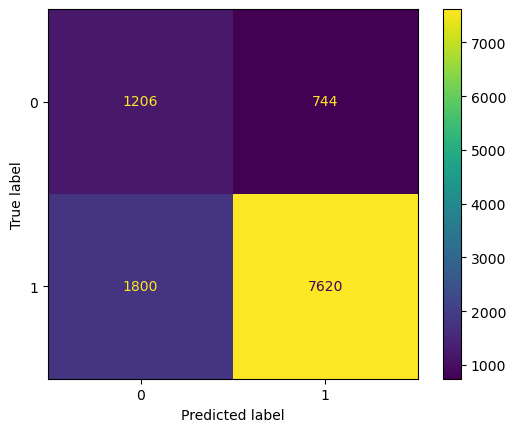

In [24]:
tree = Pipeline([("scale", StandardScaler()), ("dt", DecisionTreeClassifier(max_depth=best_max_depth))])

crossValidation(tree)

### Decision Tree Classifier performs worse than logistic regression and LDA.

The balanced accuracy is about 5% lower for the decision tree classifier, and the NPV is appreciably worse (so the decision tree classifier has far more FNs).

## Model 6: Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
param_grid = {'n_estimators': [200, 500], 'max_depth' : [3, 5, 8]}

#find best parameters using grid search cv
rfc      = RandomForestClassifier(random_state=25)
rfc_gscv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=3, scoring="accuracy", n_jobs=4)
rfc_gscv.fit(X_train_re, y_train_re)

#get parameters
rf_max_depth = rfc_gscv.best_params_["max_depth"]
rf_n_estimators = rfc_gscv.best_params_["n_estimators"]

print(f"Random forest best max_depth: {rf_max_depth}; best n_estimators: {rf_n_estimators}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Random forest best max_depth: 8; best n_estimators: 200


CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.795
Avg precision:     0.946
Avg recall:        0.817
Avg NPV:           0.466
Avg specificity:   0.773


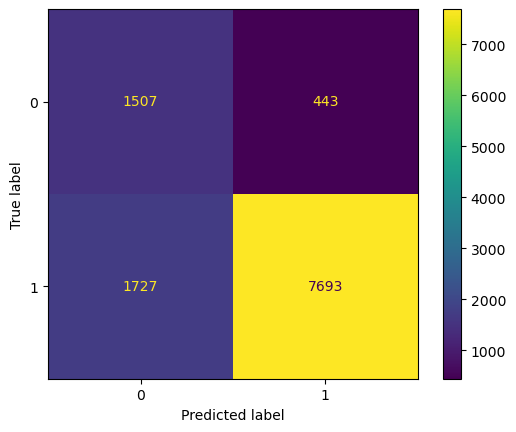

In [28]:
rf = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators)

crossValidation(rf)

### Random Forest Classifier performs well **TODO: describe**.

## Model 7: AdaBoost (default parameters)

In [29]:
from sklearn.ensemble import AdaBoostClassifier

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.773
Avg precision:     0.934
Avg recall:        0.831
Avg NPV:           0.468
Avg specificity:   0.715


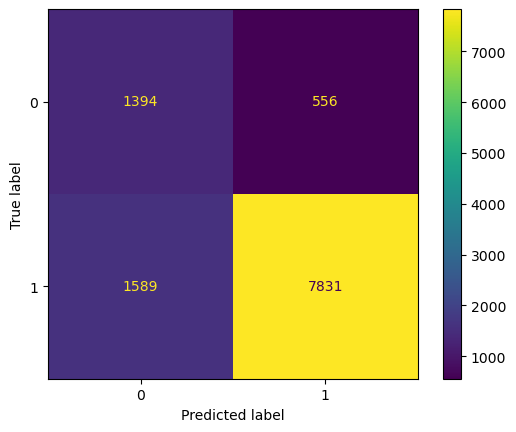

In [30]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), algorithm="SAMME")

crossValidation(ada)

### AdaBoost (with default parameters) performs about comparably to logistic regression.

## Model 8: XGBoost (default parameters)

In [31]:
from xgboost import XGBClassifier

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Classification metrics
Avg bal. accuracy: 0.723
Avg precision:     0.906
Avg recall:        0.892
Avg NPV:           0.515
Avg specificity:   0.553


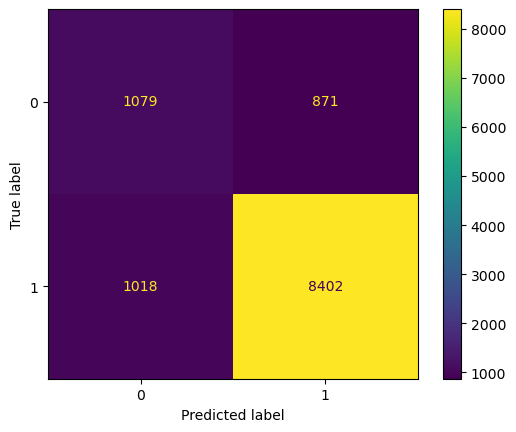

In [32]:
xgb = XGBClassifier()

crossValidation(xgb)

### XGBoost (default parameters) performs as well as, maybe better than, logistic regression.

We may benefit from hyperparameter tuning the XGBoost Classifier.